In [1]:
import pandas as pd
import numpy as np
from enum import Enum
import chess
from pathlib import Path
from typing import Tuple
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
if torch.cuda.is_available():
    device = "cuda" 
    print("CUDA version:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name())
else:
    device = "cpu"
    
device

CUDA version: 12.9
GPU: NVIDIA GeForce RTX 3070


'cuda'

In [3]:
"""
Things to check: Pooling/DropPath/cls_head_dropout > then best one add more blocks

68.33 % AdaptiveAvgPool2d((2,2)), cls_head_dropout = 0.5, 798,807, num_blocks = 10, No DropPath, v1 [Fail, overfitted]
69.72 % AdaptiveAvgPool2d((2,2)), cls_head_dropout = 0.5, 798,807, num_blocks = 10, DropPath 0.2, v1
69.65 % AdaptiveAvgPool2d((2,2)), cls_head_dropout = 0.5, 1,249,287, num_blocks = 16, DropPath 0.2, v1_16
69.75 % AdaptiveAvgPool2d((1,1)), cls_head_dropout = 0.5, 774,231, num_blocks = 10, DropPath 0.2, v2
"""

RUN_ID = "seresnet_new_v2_16"
model_save_name = "seresnet_new_v2_16"

In [4]:
class ChessDataset(Dataset):
    def __init__(self, root_dir: Path, split: str, sigma: float = 0.6):
        self.root_dir = Path(root_dir)
        self.split = split
        self.sigma = sigma
        self.num_classes = 7
        self.class_indices = torch.arange(self.num_classes, dtype=torch.float32)
        self.X = np.load(self.root_dir / f"{self.split}_X.npy", mmap_mode='r')
        self.y = np.load(self.root_dir / f"{self.split}_y.npy", mmap_mode='r')
        self.scores = np.load(self.root_dir / f"{self.split}_scores.npy", mmap_mode='r')

    def __len__(self) -> int:
        return self.X.shape[0]

    def score_to_continuous_index(self, score: float) -> float:
        """
        Maps Centipawn score to a continuous index (e.g. 400cp -> 1.5).
        """
        
        if score >= 500: 
            # Fade from 0.5 (at 500) to 0.0 (at 700)
            return max(0.0, 0.5 - (score - 500) / 200.0)
        
        if score <= -500:
            # Fade from 5.5 (at -500) to 6.0 (at -700)
            return min(6.0, 5.5 + (-500 - score) / 200.0)
        
        # Interpolate the Middle Classes
        # 300 to 500  -> Maps to 1.5 to 0.5
        if score >= 300: return 1.5 - (score - 300) / 200.0
        # 100 to 300  -> Maps to 2.5 to 1.5
        if score >= 100: return 2.5 - (score - 100) / 200.0
        # -100 to 100 -> Maps to 3.5 to 2.5
        if score >= -100: return 3.5 - (score - (-100)) / 200.0
        # -300 to -100 -> Maps to 4.5 to 3.5
        if score >= -300: return 4.5 - (score - (-300)) / 200.0
        # -500 to -300 -> Maps to 5.5 to 4.5
        if score > -500: return 5.5 - (score - (-500)) / 200.0
        
        return 3.0 
    
    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        score = self.scores[idx].item()
        target_idx = self.score_to_continuous_index(score)
        
        # Create Gaussian Distribution centered at target_idx
        dist = torch.exp(-((self.class_indices - target_idx) ** 2) / (2 * self.sigma ** 2))
        
        # Normalize so it sums to 1.0
        soft_target = dist / dist.sum()
        
        x_tensor = torch.tensor(self.X[idx], dtype=torch.float32)
        hard_label = torch.tensor(self.y[idx], dtype=torch.long)

        # return self.X[idx], self.y[idx]
        return x_tensor, soft_target, hard_label

In [5]:
BATCH_SIZE = 512
num_workers = 0 
ROOT_DIR = Path("./dataset_planes_cp/")

train_dataset = ChessDataset(root_dir=ROOT_DIR, split="train")
train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=BATCH_SIZE, 
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True)

val_dataset = ChessDataset(root_dir=ROOT_DIR, split="val")
val_dataloader = DataLoader(dataset=val_dataset, 
                            batch_size=BATCH_SIZE, 
                            num_workers=num_workers,
                            shuffle=False,
                            pin_memory=True)

test_dataset = ChessDataset(root_dir=ROOT_DIR, split="test")
test_dataloader = DataLoader(dataset=test_dataset, 
                             batch_size=BATCH_SIZE, 
                             num_workers=num_workers,
                             shuffle=False,
                             pin_memory=True)

In [6]:
import time

start = time.time()
for i, (X, y, y_hard) in enumerate(train_dataloader):
    if i == 100:  # measure 100 batches
        break
print("Avg batch load time:", (time.time() - start) / 100)


Avg batch load time: 0.04096527099609375


In [7]:
Xb, _, yb = next(iter(train_dataloader))
print("X batch shape:", Xb.shape, "dtype:", Xb.dtype)
print("y batch shape:", yb.shape, "dtype:", yb.dtype)

X batch shape: torch.Size([512, 19, 8, 8]) dtype: torch.float32
y batch shape: torch.Size([512]) dtype: torch.int64


In [8]:
class PositionLabel(Enum):
    WHITE_WINNING = 0
    WHITE_DECISIVE = 1
    WHITE_BETTER = 2
    EQUAL = 3
    BLACK_BETTER = 4
    BLACK_DECISIVE = 5
    BLACK_WINNING = 6

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, drop_prob=0.0):
        super().__init__()
        
        # bias = False because BatchNorm effectively cancels any bias term
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 =  nn.BatchNorm2d(channels)
        self.bn2 =  nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()
        self.se = SEBlock(channels, reduction=8)
        self.drop_path = DropPath(drop_prob) if drop_prob > 0. else nn.Identity()

    # x is shape [19,8,8]
    def forward(self, x):
        identity = x 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.dropout(x) # adding causes val acc drop 15%
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.se(x)
        x = self.drop_path(x)
        x += identity
        x = self.relu(x)
        # x = self.dropout(x) # adding causes val acc drop 15%
        return x

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()
        # Squeeze: Global Average Pooling (turns Cx8x8 tensor into Cx1x1 tensor (not flattened))
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Excitation: A tiny fully connected network to learn channel weights
        self.mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction), # Compress
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels), # Expand
            nn.Sigmoid() # Output a (0.0 to 1.0) for importance
        )

    def forward(self, x):
        batch, channels, _, _ = x.size()
        
        # Calculate importance scores
        y = self.avg_pool(x).view(batch, channels)
        y = self.mlp(y).view(batch, channels, 1, 1)
        
        # Scale the original input by these scores
        return x * y.expand_as(x)
    
class DropPath(nn.Module):
    def __init__(self, drop_prob: float = 0.):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)

        # Create a mask of 1s and 0s
        random_tensor = x.new_empty(shape).bernoulli_(keep_prob)

        # Apply mask and scale output to maintain expected value
        return x.div(keep_prob) * random_tensor
    
class SEResNet(nn.Module):
    def __init__(self, in_channels=19, channels=64, num_blocks=10, num_classes=7, drop_path_rate=0.2):
        super().__init__()
        # Initial convolution on board
        self.initialconv = nn.Sequential(
            nn.Conv2d(in_channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU()
        )

        dpr = [x.item() for x in torch.linspace(start=0, end=drop_path_rate, steps=num_blocks)]

        # Main residual block
        blocks = []
        for i in range(num_blocks):
            blocks.append(ResidualBlock(channels, drop_prob=dpr[i]))
        self.res_tower = nn.Sequential(*blocks)

        # Reduces channels to 32 before flattening
        self.bottleneck_channels = 32
        self.bottleneck = nn.Sequential(
            nn.Conv2d(channels, self.bottleneck_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(self.bottleneck_channels),
            nn.ReLU()
        )

        # Classifier
        # self.flatten_dim = self.bottleneck_channels * 8 * 8
        self.flatten_dim = self.bottleneck_channels * 1 * 1
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)      
        )

    def forward(self, x):
        x = self.initialconv(x)
        x = self.res_tower(x)
        x = self.bottleneck(x)
        x = self.classifier(x)
        return x

In [10]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scaler: torch.amp.GradScaler,
               device=device) -> tuple[float, float]:
    """
    Performs one training epoch for the given model.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in train mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y, _) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # X and Y are both shape (BATCH_SIZE,)

        # Reset gradients
        optimizer.zero_grad()

        # Forward Pass
        with torch.amp.autocast(device):
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
        
        # Backpropagation
        scaler.scale(loss).backward()

        # Update weights
        scaler.step(optimizer)
        scaler.update()  
        
        train_loss += loss.item()

        # Calculate accuracy metrics
        """softmax and argmax dim=1 because tensor of shape (batchsize, num_classes)"""
        y_pred_class = torch.argmax(y_pred, dim=-1) # y_pred_class.shape = (BATCH_SIZE,)
        # train_acc += (y_pred_class == y).sum().item()/len(y_pred)

        # Remove for non prob ablation
        y_true_class = torch.argmax(y, dim=-1)
        train_acc += (y_pred_class == y_true_class).sum().item()/len(y_pred)
        
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [11]:
def eval_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device) -> tuple[float, float]:
    """
    Evaluates the given model on the given dataloader without gradient updates.
    Dataloader should either be the validation or test dataloader.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in eval mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y, y_hard) in enumerate(dataloader):
            X, y, y_hard = X.to(device), y.to(device), y_hard.to(device)

            # Forward Pass
            test_pred = model(X)

            # Calculate the loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate accuracy metrics
            test_pred_labels = torch.argmax(test_pred, dim=1)
            test_acc += (test_pred_labels == y_hard).sum().item() / len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [12]:
from tqdm import tqdm
import copy

def run_experiment(model: torch.nn.Module,
                   model_save_name: str,
                   train_dataloader: torch.utils.data.DataLoader,
                   val_dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   optimizer: torch.optim.Optimizer,
                   scaler: torch.amp.GradScaler,
                   epochs: int,
                   patience: int,
                   device=device):
    
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []}
    
    best_val_acc = 0.0
    best_model_weights = None
    patience_counter = 0 
    
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, mode='min', factor=0.1, patience=3
    # )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=epochs,      
        eta_min=1e-6         
    )
    
    print(f"Starting Training: {model_save_name}")

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device,
                                           scaler=scaler)
        val_loss, val_acc = eval_step(model=model,
                                      dataloader=val_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)
        
        # scheduler.step(val_loss)
        scheduler.step()
        
        if val_acc > best_val_acc: 
            best_val_acc = val_acc
            best_model_weights = copy.deepcopy(model.state_dict())
            patience_counter = 0
            
            print(f"Epoch: {epoch} | New Best Val Acc: {val_acc:.4f} (Saved)")
            torch.save(model.state_dict(), f"models/{model_save_name}.pth")
        else:
            patience_counter += 1
            print(f"Epoch: No improvement. Patience {patience_counter}/{patience}")

        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        if patience_counter >= patience:
            print(f"\n[Early Stopping] No improvement for {patience} epochs. Stopping.")
            break 

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"\nLoaded best model weights with Val Acc: {best_val_acc:.4f}")

    return results

In [13]:
from torchinfo import summary

model = SEResNet(in_channels=19, 
                 channels=64, 
                 num_blocks=16, 
                 num_classes=7).to(device)

summary(model, input_size=(BATCH_SIZE, 19, 8, 8))

Layer (type:depth-idx)                        Output Shape              Param #
SEResNet                                      [512, 7]                  --
├─Sequential: 1-1                             [512, 64, 8, 8]           --
│    └─Conv2d: 2-1                            [512, 64, 8, 8]           10,944
│    └─BatchNorm2d: 2-2                       [512, 64, 8, 8]           128
│    └─ReLU: 2-3                              [512, 64, 8, 8]           --
├─Sequential: 1-2                             [512, 64, 8, 8]           --
│    └─ResidualBlock: 2-4                     [512, 64, 8, 8]           --
│    │    └─Conv2d: 3-1                       [512, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-2                  [512, 64, 8, 8]           128
│    │    └─ReLU: 3-3                         [512, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                       [512, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-5                  [512, 64, 8, 8]           128
│    

In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(),
                              lr=0.001,
                              weight_decay=0.01)

scaler = torch.amp.GradScaler("cuda")

result = run_experiment(model=model,
                        model_save_name=model_save_name,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        scaler=scaler,
                        epochs=NUM_EPOCHS,
                        patience=NUM_EPOCHS + 1,
                        device=device)

Starting Training: seresnet_new_v2_16


  1%|          | 1/100 [11:00<18:10:36, 660.98s/it]

Epoch: 0 | New Best Val Acc: 0.4523 (Saved)
Epoch: 0 | Train Loss: 1.3728 | Val Loss: 1.4782 | Val Acc: 0.4523


  2%|▏         | 2/100 [22:00<17:58:24, 660.25s/it]

Epoch: 1 | New Best Val Acc: 0.5760 (Saved)
Epoch: 1 | Train Loss: 1.2536 | Val Loss: 1.2479 | Val Acc: 0.5760


  3%|▎         | 3/100 [32:36<17:29:08, 648.95s/it]

Epoch: 2 | New Best Val Acc: 0.5918 (Saved)
Epoch: 2 | Train Loss: 1.2047 | Val Loss: 1.2170 | Val Acc: 0.5918


  4%|▍         | 4/100 [43:13<17:10:49, 644.27s/it]

Epoch: 3 | New Best Val Acc: 0.5945 (Saved)
Epoch: 3 | Train Loss: 1.1759 | Val Loss: 1.2180 | Val Acc: 0.5945


  5%|▌         | 5/100 [53:47<16:54:25, 640.69s/it]

Epoch: No improvement. Patience 1/101
Epoch: 4 | Train Loss: 1.1564 | Val Loss: 1.2627 | Val Acc: 0.5703


  6%|▌         | 6/100 [1:04:30<16:44:38, 641.26s/it]

Epoch: 5 | New Best Val Acc: 0.6351 (Saved)
Epoch: 5 | Train Loss: 1.1418 | Val Loss: 1.1523 | Val Acc: 0.6351


  7%|▋         | 7/100 [1:15:07<16:32:05, 640.06s/it]

Epoch: 6 | New Best Val Acc: 0.6593 (Saved)
Epoch: 6 | Train Loss: 1.1303 | Val Loss: 1.1281 | Val Acc: 0.6593


  8%|▊         | 8/100 [1:26:20<16:37:37, 650.63s/it]

Epoch: No improvement. Patience 1/101
Epoch: 7 | Train Loss: 1.1209 | Val Loss: 1.1438 | Val Acc: 0.6443


  9%|▉         | 9/100 [1:36:53<16:18:16, 645.02s/it]

Epoch: No improvement. Patience 2/101
Epoch: 8 | Train Loss: 1.1130 | Val Loss: 1.1421 | Val Acc: 0.6416


 10%|█         | 10/100 [1:47:41<16:08:41, 645.80s/it]

Epoch: No improvement. Patience 3/101
Epoch: 9 | Train Loss: 1.1062 | Val Loss: 1.1969 | Val Acc: 0.6104


 11%|█         | 11/100 [1:58:35<16:01:55, 648.49s/it]

Epoch: 10 | New Best Val Acc: 0.6608 (Saved)
Epoch: 10 | Train Loss: 1.1005 | Val Loss: 1.1209 | Val Acc: 0.6608


 12%|█▏        | 12/100 [2:09:11<15:45:27, 644.63s/it]

Epoch: 11 | New Best Val Acc: 0.6626 (Saved)
Epoch: 11 | Train Loss: 1.0954 | Val Loss: 1.1177 | Val Acc: 0.6626


 13%|█▎        | 13/100 [2:19:41<15:28:21, 640.25s/it]

Epoch: No improvement. Patience 1/101
Epoch: 12 | Train Loss: 1.0907 | Val Loss: 1.1234 | Val Acc: 0.6587


 14%|█▍        | 14/100 [2:30:12<15:13:25, 637.27s/it]

Epoch: No improvement. Patience 2/101
Epoch: 13 | Train Loss: 1.0865 | Val Loss: 1.1178 | Val Acc: 0.6617


 15%|█▌        | 15/100 [2:41:21<15:16:22, 646.86s/it]

Epoch: 14 | New Best Val Acc: 0.6837 (Saved)
Epoch: 14 | Train Loss: 1.0826 | Val Loss: 1.0927 | Val Acc: 0.6837


 16%|█▌        | 16/100 [2:51:58<15:01:48, 644.15s/it]

Epoch: No improvement. Patience 1/101
Epoch: 15 | Train Loss: 1.0792 | Val Loss: 1.1056 | Val Acc: 0.6709


 17%|█▋        | 17/100 [3:02:21<14:42:08, 637.69s/it]

Epoch: No improvement. Patience 2/101
Epoch: 16 | Train Loss: 1.0759 | Val Loss: 1.0932 | Val Acc: 0.6817


 18%|█▊        | 18/100 [3:12:54<14:29:25, 636.17s/it]

Epoch: No improvement. Patience 3/101
Epoch: 17 | Train Loss: 1.0730 | Val Loss: 1.1023 | Val Acc: 0.6724


 19%|█▉        | 19/100 [3:24:09<14:34:50, 648.04s/it]

Epoch: No improvement. Patience 4/101
Epoch: 18 | Train Loss: 1.0699 | Val Loss: 1.1270 | Val Acc: 0.6586


 20%|██        | 20/100 [3:35:16<14:31:23, 653.54s/it]

Epoch: No improvement. Patience 5/101
Epoch: 19 | Train Loss: 1.0674 | Val Loss: 1.1055 | Val Acc: 0.6754


 21%|██        | 21/100 [3:46:22<14:25:23, 657.26s/it]

Epoch: 20 | New Best Val Acc: 0.6837 (Saved)
Epoch: 20 | Train Loss: 1.0650 | Val Loss: 1.0912 | Val Acc: 0.6837


 22%|██▏       | 22/100 [3:57:24<14:16:17, 658.68s/it]

Epoch: No improvement. Patience 1/101
Epoch: 21 | Train Loss: 1.0625 | Val Loss: 1.1036 | Val Acc: 0.6766


 23%|██▎       | 23/100 [4:08:58<14:18:50, 669.23s/it]

Epoch: 22 | New Best Val Acc: 0.6846 (Saved)
Epoch: 22 | Train Loss: 1.0607 | Val Loss: 1.0923 | Val Acc: 0.6846


 24%|██▍       | 24/100 [4:20:47<14:22:59, 681.31s/it]

Epoch: No improvement. Patience 1/101
Epoch: 23 | Train Loss: 1.0584 | Val Loss: 1.0962 | Val Acc: 0.6822


 25%|██▌       | 25/100 [4:32:08<14:11:24, 681.13s/it]

Epoch: No improvement. Patience 2/101
Epoch: 24 | Train Loss: 1.0564 | Val Loss: 1.1024 | Val Acc: 0.6757


 26%|██▌       | 26/100 [4:43:30<14:00:34, 681.55s/it]

Epoch: No improvement. Patience 3/101
Epoch: 25 | Train Loss: 1.0546 | Val Loss: 1.0932 | Val Acc: 0.6842


 27%|██▋       | 27/100 [4:54:23<13:38:37, 672.84s/it]

Epoch: No improvement. Patience 4/101
Epoch: 26 | Train Loss: 1.0527 | Val Loss: 1.0938 | Val Acc: 0.6827


 28%|██▊       | 28/100 [5:04:58<13:13:45, 661.47s/it]

Epoch: No improvement. Patience 5/101
Epoch: 27 | Train Loss: 1.0508 | Val Loss: 1.0961 | Val Acc: 0.6788


 29%|██▉       | 29/100 [5:15:18<12:48:05, 649.09s/it]

Epoch: No improvement. Patience 6/101
Epoch: 28 | Train Loss: 1.0492 | Val Loss: 1.0937 | Val Acc: 0.6806


 30%|███       | 30/100 [5:25:36<12:26:14, 639.64s/it]

Epoch: 29 | New Best Val Acc: 0.6919 (Saved)
Epoch: 29 | Train Loss: 1.0474 | Val Loss: 1.0852 | Val Acc: 0.6919


 31%|███       | 31/100 [5:35:53<12:08:03, 633.10s/it]

Epoch: No improvement. Patience 1/101
Epoch: 30 | Train Loss: 1.0460 | Val Loss: 1.0824 | Val Acc: 0.6907


 32%|███▏      | 32/100 [5:46:34<12:00:02, 635.33s/it]

Epoch: No improvement. Patience 2/101
Epoch: 31 | Train Loss: 1.0444 | Val Loss: 1.0852 | Val Acc: 0.6887


 33%|███▎      | 33/100 [5:57:23<11:54:05, 639.49s/it]

Epoch: No improvement. Patience 3/101
Epoch: 32 | Train Loss: 1.0430 | Val Loss: 1.1184 | Val Acc: 0.6662


 34%|███▍      | 34/100 [6:07:55<11:40:53, 637.17s/it]

Epoch: 33 | New Best Val Acc: 0.6923 (Saved)
Epoch: 33 | Train Loss: 1.0416 | Val Loss: 1.0862 | Val Acc: 0.6923


 35%|███▌      | 35/100 [6:18:55<11:37:33, 643.91s/it]

Epoch: 34 | New Best Val Acc: 0.6967 (Saved)
Epoch: 34 | Train Loss: 1.0401 | Val Loss: 1.0793 | Val Acc: 0.6967


 36%|███▌      | 36/100 [6:29:50<11:30:38, 647.48s/it]

Epoch: No improvement. Patience 1/101
Epoch: 35 | Train Loss: 1.0385 | Val Loss: 1.0842 | Val Acc: 0.6916


 37%|███▋      | 37/100 [6:40:27<11:16:21, 644.15s/it]

Epoch: No improvement. Patience 2/101
Epoch: 36 | Train Loss: 1.0372 | Val Loss: 1.0888 | Val Acc: 0.6887


 38%|███▊      | 38/100 [6:50:49<10:58:44, 637.49s/it]

Epoch: No improvement. Patience 3/101
Epoch: 37 | Train Loss: 1.0358 | Val Loss: 1.0858 | Val Acc: 0.6914


 39%|███▉      | 39/100 [7:01:35<10:50:46, 640.10s/it]

Epoch: No improvement. Patience 4/101
Epoch: 38 | Train Loss: 1.0341 | Val Loss: 1.0847 | Val Acc: 0.6888


 40%|████      | 40/100 [7:12:30<10:44:28, 644.48s/it]

Epoch: No improvement. Patience 5/101
Epoch: 39 | Train Loss: 1.0326 | Val Loss: 1.0859 | Val Acc: 0.6944


 41%|████      | 41/100 [7:23:01<10:29:59, 640.68s/it]

Epoch: No improvement. Patience 6/101
Epoch: 40 | Train Loss: 1.0315 | Val Loss: 1.1122 | Val Acc: 0.6788


 42%|████▏     | 42/100 [7:33:28<10:15:13, 636.44s/it]

Epoch: No improvement. Patience 7/101
Epoch: 41 | Train Loss: 1.0300 | Val Loss: 1.0875 | Val Acc: 0.6922


 43%|████▎     | 43/100 [7:43:54<10:01:34, 633.23s/it]

Epoch: No improvement. Patience 8/101
Epoch: 42 | Train Loss: 1.0286 | Val Loss: 1.0897 | Val Acc: 0.6905


 44%|████▍     | 44/100 [7:54:23<9:49:53, 632.02s/it] 

Epoch: No improvement. Patience 9/101
Epoch: 43 | Train Loss: 1.0271 | Val Loss: 1.0869 | Val Acc: 0.6891


 45%|████▌     | 45/100 [8:04:57<9:40:01, 632.76s/it]

Epoch: No improvement. Patience 10/101
Epoch: 44 | Train Loss: 1.0257 | Val Loss: 1.0853 | Val Acc: 0.6923


 46%|████▌     | 46/100 [8:15:38<9:31:41, 635.22s/it]

Epoch: No improvement. Patience 11/101
Epoch: 45 | Train Loss: 1.0242 | Val Loss: 1.1056 | Val Acc: 0.6799


 47%|████▋     | 47/100 [8:26:30<9:25:34, 640.27s/it]

Epoch: No improvement. Patience 12/101
Epoch: 46 | Train Loss: 1.0229 | Val Loss: 1.0920 | Val Acc: 0.6890


 48%|████▊     | 48/100 [8:37:26<9:18:49, 644.81s/it]

Epoch: No improvement. Patience 13/101
Epoch: 47 | Train Loss: 1.0215 | Val Loss: 1.0830 | Val Acc: 0.6953


 49%|████▉     | 49/100 [8:48:26<9:11:58, 649.38s/it]

Epoch: No improvement. Patience 14/101
Epoch: 48 | Train Loss: 1.0200 | Val Loss: 1.0823 | Val Acc: 0.6963


 50%|█████     | 50/100 [8:59:14<9:00:47, 648.95s/it]

Epoch: No improvement. Patience 15/101
Epoch: 49 | Train Loss: 1.0185 | Val Loss: 1.1056 | Val Acc: 0.6805


 51%|█████     | 51/100 [9:10:26<8:55:44, 656.00s/it]

Epoch: No improvement. Patience 16/101
Epoch: 50 | Train Loss: 1.0170 | Val Loss: 1.0942 | Val Acc: 0.6914


 52%|█████▏    | 52/100 [9:21:36<8:48:06, 660.14s/it]

Epoch: No improvement. Patience 17/101
Epoch: 51 | Train Loss: 1.0154 | Val Loss: 1.1105 | Val Acc: 0.6847


 53%|█████▎    | 53/100 [9:32:33<8:36:29, 659.35s/it]

Epoch: No improvement. Patience 18/101
Epoch: 52 | Train Loss: 1.0140 | Val Loss: 1.0855 | Val Acc: 0.6924


 54%|█████▍    | 54/100 [9:43:39<8:26:58, 661.27s/it]

Epoch: No improvement. Patience 19/101
Epoch: 53 | Train Loss: 1.0125 | Val Loss: 1.0884 | Val Acc: 0.6944


 55%|█████▌    | 55/100 [9:54:37<8:15:08, 660.19s/it]

Epoch: 54 | New Best Val Acc: 0.6973 (Saved)
Epoch: 54 | Train Loss: 1.0110 | Val Loss: 1.0838 | Val Acc: 0.6973


 56%|█████▌    | 56/100 [10:05:15<7:59:17, 653.58s/it]

Epoch: No improvement. Patience 1/101
Epoch: 55 | Train Loss: 1.0093 | Val Loss: 1.0861 | Val Acc: 0.6958


 57%|█████▋    | 57/100 [10:15:41<7:42:31, 645.39s/it]

Epoch: No improvement. Patience 2/101
Epoch: 56 | Train Loss: 1.0077 | Val Loss: 1.0861 | Val Acc: 0.6957


 58%|█████▊    | 58/100 [10:26:07<7:27:32, 639.34s/it]

Epoch: No improvement. Patience 3/101
Epoch: 57 | Train Loss: 1.0061 | Val Loss: 1.0851 | Val Acc: 0.6969


 59%|█████▉    | 59/100 [10:36:39<7:15:29, 637.30s/it]

Epoch: 58 | New Best Val Acc: 0.6998 (Saved)
Epoch: 58 | Train Loss: 1.0046 | Val Loss: 1.0850 | Val Acc: 0.6998


 60%|██████    | 60/100 [10:47:23<7:06:16, 639.41s/it]

Epoch: No improvement. Patience 1/101
Epoch: 59 | Train Loss: 1.0028 | Val Loss: 1.0906 | Val Acc: 0.6959


 61%|██████    | 61/100 [10:58:08<6:56:32, 640.84s/it]

Epoch: No improvement. Patience 2/101
Epoch: 60 | Train Loss: 1.0011 | Val Loss: 1.0866 | Val Acc: 0.6994


 62%|██████▏   | 62/100 [11:08:28<6:41:55, 634.63s/it]

Epoch: No improvement. Patience 3/101
Epoch: 61 | Train Loss: 0.9993 | Val Loss: 1.0907 | Val Acc: 0.6953


 63%|██████▎   | 63/100 [11:18:48<6:28:38, 630.23s/it]

Epoch: No improvement. Patience 4/101
Epoch: 62 | Train Loss: 0.9977 | Val Loss: 1.0931 | Val Acc: 0.6957


 64%|██████▍   | 64/100 [11:29:24<6:19:08, 631.90s/it]

Epoch: No improvement. Patience 5/101
Epoch: 63 | Train Loss: 0.9961 | Val Loss: 1.0877 | Val Acc: 0.6990


 65%|██████▌   | 65/100 [11:39:58<6:09:07, 632.79s/it]

Epoch: No improvement. Patience 6/101
Epoch: 64 | Train Loss: 0.9940 | Val Loss: 1.0874 | Val Acc: 0.6992


 66%|██████▌   | 66/100 [11:50:29<5:58:09, 632.05s/it]

Epoch: No improvement. Patience 7/101
Epoch: 65 | Train Loss: 0.9925 | Val Loss: 1.0925 | Val Acc: 0.6975


 67%|██████▋   | 67/100 [12:01:05<5:48:24, 633.46s/it]

Epoch: No improvement. Patience 8/101
Epoch: 66 | Train Loss: 0.9906 | Val Loss: 1.1151 | Val Acc: 0.6845


 68%|██████▊   | 68/100 [12:11:21<5:34:59, 628.11s/it]

Epoch: No improvement. Patience 9/101
Epoch: 67 | Train Loss: 0.9887 | Val Loss: 1.0993 | Val Acc: 0.6959


 69%|██████▉   | 69/100 [12:21:36<5:22:28, 624.13s/it]

Epoch: No improvement. Patience 10/101
Epoch: 68 | Train Loss: 0.9868 | Val Loss: 1.0944 | Val Acc: 0.6966


 70%|███████   | 70/100 [12:31:51<5:10:39, 621.30s/it]

Epoch: No improvement. Patience 11/101
Epoch: 69 | Train Loss: 0.9851 | Val Loss: 1.0938 | Val Acc: 0.6982


 71%|███████   | 71/100 [12:42:06<4:59:23, 619.44s/it]

Epoch: No improvement. Patience 12/101
Epoch: 70 | Train Loss: 0.9832 | Val Loss: 1.0970 | Val Acc: 0.6974


 72%|███████▏  | 72/100 [12:52:20<4:48:22, 617.95s/it]

Epoch: No improvement. Patience 13/101
Epoch: 71 | Train Loss: 0.9813 | Val Loss: 1.1112 | Val Acc: 0.6926


 73%|███████▎  | 73/100 [13:02:35<4:37:41, 617.10s/it]

Epoch: No improvement. Patience 14/101
Epoch: 72 | Train Loss: 0.9796 | Val Loss: 1.1002 | Val Acc: 0.6993


 74%|███████▍  | 74/100 [13:12:50<4:27:06, 616.39s/it]

Epoch: 73 | New Best Val Acc: 0.7007 (Saved)
Epoch: 73 | Train Loss: 0.9778 | Val Loss: 1.0980 | Val Acc: 0.7007


 75%|███████▌  | 75/100 [13:23:10<4:17:12, 617.30s/it]

Epoch: No improvement. Patience 1/101
Epoch: 74 | Train Loss: 0.9758 | Val Loss: 1.1036 | Val Acc: 0.6989


 76%|███████▌  | 76/100 [13:33:26<4:06:49, 617.06s/it]

Epoch: No improvement. Patience 2/101
Epoch: 75 | Train Loss: 0.9740 | Val Loss: 1.1043 | Val Acc: 0.6990


 77%|███████▋  | 77/100 [13:43:45<3:56:47, 617.70s/it]

Epoch: No improvement. Patience 3/101
Epoch: 76 | Train Loss: 0.9722 | Val Loss: 1.1054 | Val Acc: 0.7003


 78%|███████▊  | 78/100 [13:54:02<3:46:24, 617.48s/it]

Epoch: No improvement. Patience 4/101
Epoch: 77 | Train Loss: 0.9704 | Val Loss: 1.1072 | Val Acc: 0.6990


 79%|███████▉  | 79/100 [14:04:23<3:36:28, 618.51s/it]

Epoch: No improvement. Patience 5/101
Epoch: 78 | Train Loss: 0.9686 | Val Loss: 1.1084 | Val Acc: 0.6993


 80%|████████  | 80/100 [14:14:45<3:26:30, 619.51s/it]

Epoch: No improvement. Patience 6/101
Epoch: 79 | Train Loss: 0.9669 | Val Loss: 1.1094 | Val Acc: 0.6996


 81%|████████  | 81/100 [14:25:05<3:16:15, 619.76s/it]

Epoch: No improvement. Patience 7/101
Epoch: 80 | Train Loss: 0.9655 | Val Loss: 1.1106 | Val Acc: 0.7002


 82%|████████▏ | 82/100 [14:35:25<3:05:54, 619.72s/it]

Epoch: 81 | New Best Val Acc: 0.7014 (Saved)
Epoch: 81 | Train Loss: 0.9636 | Val Loss: 1.1112 | Val Acc: 0.7014


 83%|████████▎ | 83/100 [14:45:47<2:55:46, 620.39s/it]

Epoch: No improvement. Patience 1/101
Epoch: 82 | Train Loss: 0.9622 | Val Loss: 1.1116 | Val Acc: 0.6996


 84%|████████▍ | 84/100 [14:56:09<2:45:33, 620.83s/it]

Epoch: No improvement. Patience 2/101
Epoch: 83 | Train Loss: 0.9605 | Val Loss: 1.1142 | Val Acc: 0.7005


 85%|████████▌ | 85/100 [15:06:35<2:35:35, 622.35s/it]

Epoch: No improvement. Patience 3/101
Epoch: 84 | Train Loss: 0.9591 | Val Loss: 1.1153 | Val Acc: 0.6996


 86%|████████▌ | 86/100 [15:16:59<2:25:21, 623.00s/it]

Epoch: No improvement. Patience 4/101
Epoch: 85 | Train Loss: 0.9578 | Val Loss: 1.1169 | Val Acc: 0.7007


 87%|████████▋ | 87/100 [15:27:23<2:15:02, 623.24s/it]

Epoch: No improvement. Patience 5/101
Epoch: 86 | Train Loss: 0.9566 | Val Loss: 1.1181 | Val Acc: 0.6983


 88%|████████▊ | 88/100 [15:37:47<2:04:40, 623.41s/it]

Epoch: No improvement. Patience 6/101
Epoch: 87 | Train Loss: 0.9552 | Val Loss: 1.1195 | Val Acc: 0.6999


 89%|████████▉ | 89/100 [15:48:10<1:54:18, 623.51s/it]

Epoch: No improvement. Patience 7/101
Epoch: 88 | Train Loss: 0.9540 | Val Loss: 1.1203 | Val Acc: 0.7002


 90%|█████████ | 90/100 [15:58:34<1:43:54, 623.45s/it]

Epoch: No improvement. Patience 8/101
Epoch: 89 | Train Loss: 0.9531 | Val Loss: 1.1227 | Val Acc: 0.6982


 91%|█████████ | 91/100 [16:08:58<1:33:33, 623.68s/it]

Epoch: No improvement. Patience 9/101
Epoch: 90 | Train Loss: 0.9520 | Val Loss: 1.1194 | Val Acc: 0.7013


 92%|█████████▏| 92/100 [16:19:21<1:23:08, 623.53s/it]

Epoch: No improvement. Patience 10/101
Epoch: 91 | Train Loss: 0.9511 | Val Loss: 1.1216 | Val Acc: 0.6998


 93%|█████████▎| 93/100 [16:29:45<1:12:45, 623.63s/it]

Epoch: No improvement. Patience 11/101
Epoch: 92 | Train Loss: 0.9506 | Val Loss: 1.1246 | Val Acc: 0.6996


 94%|█████████▍| 94/100 [16:40:08<1:02:21, 623.56s/it]

Epoch: No improvement. Patience 12/101
Epoch: 93 | Train Loss: 0.9498 | Val Loss: 1.1263 | Val Acc: 0.6992


 95%|█████████▌| 95/100 [16:50:32<51:57, 623.48s/it]  

Epoch: No improvement. Patience 13/101
Epoch: 94 | Train Loss: 0.9492 | Val Loss: 1.1232 | Val Acc: 0.7013


 96%|█████████▌| 96/100 [17:00:56<41:34, 623.64s/it]

Epoch: No improvement. Patience 14/101
Epoch: 95 | Train Loss: 0.9488 | Val Loss: 1.1254 | Val Acc: 0.6997


 97%|█████████▋| 97/100 [17:11:19<31:10, 623.65s/it]

Epoch: No improvement. Patience 15/101
Epoch: 96 | Train Loss: 0.9484 | Val Loss: 1.1263 | Val Acc: 0.7004


 98%|█████████▊| 98/100 [17:21:44<20:47, 623.91s/it]

Epoch: No improvement. Patience 16/101
Epoch: 97 | Train Loss: 0.9481 | Val Loss: 1.1270 | Val Acc: 0.7002


 99%|█████████▉| 99/100 [17:32:08<10:23, 623.85s/it]

Epoch: No improvement. Patience 17/101
Epoch: 98 | Train Loss: 0.9479 | Val Loss: 1.1276 | Val Acc: 0.6993


100%|██████████| 100/100 [17:42:32<00:00, 637.52s/it]

Epoch: No improvement. Patience 18/101
Epoch: 99 | Train Loss: 0.9478 | Val Loss: 1.1251 | Val Acc: 0.7005

Loaded best model weights with Val Acc: 0.7014


In [15]:
piece_to_index = {"P":0,
                  "N":1,
                  "B":2,
                  "R":3,
                  "Q":4,
                  "K":5,
                  "p":6,
                  "n":7,
                  "b":8,
                  "r":9,
                  "q":10,
                  "k":11}

In [16]:
def fen_to_tensor(fen):
    """
    Converts FEN into a (19, 8, 8) tensor.
    """
    board = chess.Board(fen)
    tensor = np.zeros((19, 8, 8), dtype=np.uint8)

    piece_to_channel = {
        "P": 0, "N": 1, "B": 2, "R": 3, "Q": 4, "K": 5,
        "p": 6, "n": 7, "b": 8, "r": 9, "q": 10, "k": 11
    }

    for square, piece in board.piece_map().items():
        channel = piece_to_channel[piece.symbol()]
        row, col = divmod(square, 8)
        tensor[channel, row, col] = 1

    
    if board.turn == chess.WHITE:
        tensor[12, :, :] = 1
    if board.has_kingside_castling_rights(chess.WHITE):
        tensor[13, :, :] = 1
    if board.has_queenside_castling_rights(chess.WHITE):
        tensor[14, :, :] = 1
    if board.has_kingside_castling_rights(chess.BLACK):
        tensor[15, :, :] = 1
    if board.has_queenside_castling_rights(chess.BLACK):
        tensor[16, :, :] = 1
    if board.is_check():
        tensor[17, :, :] = 1

    if board.ep_square is not None:
        row, col = divmod(board.ep_square, 8)
        tensor[18, row, col] = 1

    return tensor

Model Prediction:  5
Stockfish Evaluation:  5


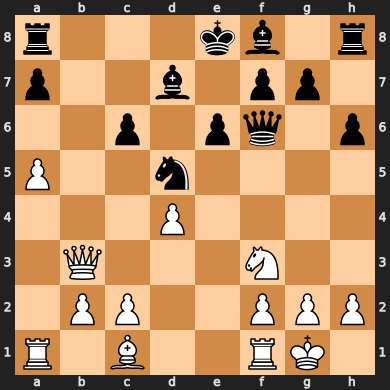

In [17]:
def check_model_prediction(model: torch.nn.Module,
                           random_fen: str,
                           fen_class: int,
                           device=device):
    """Takes the given fen to see the board, predicted score and actual score"""

    numpy_fen = fen_to_tensor(random_fen)
    torch_fen = torch.tensor(numpy_fen, dtype=torch.float32).unsqueeze(0).to(device)
    pred = torch.argmax(model(torch_fen), dim=-1)
    print("Model Prediction: ", pred.item())
    print("Stockfish Evaluation: ", fen_class)

# Remember to update fen_class manually
random_fen = "r3kb1r/p2b1pp1/2p1pq1p/P2n4/3P4/1Q3N2/1PP2PPP/R1B2RK1 b kq - 2 14"
check_model_prediction(model=model,
                       random_fen=random_fen,
                       fen_class=5, # remember to manually set 
                       device=device)

board = chess.Board(random_fen)
board

In [18]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.inference_mode():
    for X, y, y_hard in val_dataloader:
        X = X.to(device)
        preds = model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_hard.numpy())

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.81      0.84      0.82     85601
           1       0.66      0.63      0.64     85601
           2       0.64      0.64      0.64     85601
           3       0.65      0.66      0.65     85601
           4       0.67      0.66      0.66     85601
           5       0.65      0.66      0.65     85601
           6       0.82      0.82      0.82     85601

    accuracy                           0.70    599207
   macro avg       0.70      0.70      0.70    599207
weighted avg       0.70      0.70      0.70    599207



In [19]:
import json
import time

LOGS_DIR = f"experiments/logs/{model_save_name}"

def save_config_metadata(experiment_name: str, 
                         model: torch.nn.Module, 
                         hyperparams: dict, 
                         dataset_paths: dict,
                         save_dir: str = LOGS_DIR):
    """
    Saves all 'static' setup details: Model architecture, parameter counts, 
    datasets used, and hyperparameters.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)

    # Model Metadata
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    config_data = {
        "experiment_name": experiment_name,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model_architecture": {
            "class_name": model.__class__.__name__,
            "total_parameters": total_params,
            "trainable_parameters": trainable_params,
            "structure_summary": str(model)
        },
        "datasets": dataset_paths,
        "hyperparameters": hyperparams,
        "device": torch.cuda.get_device_name() if torch.cuda.is_available() else "cpu"
    }

    file_path = f"{save_dir}/{experiment_name}_config.json"
    with open(file_path, "w") as f:
        json.dump(config_data, f, indent=4)
    
    print(f"[Config] Saved metadata to {file_path}")
    
def save_training_logs(experiment_name: str, 
                       results_dict: dict, 
                       save_dir: str = LOGS_DIR):
    """
    Saves the epoch-by-epoch learning curves (Loss/Acc) to CSV.
    Expects results_dict to be the output from your run_experiment function.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    df = pd.DataFrame(results_dict)
    
    if "epoch" not in df.columns:
        df["epoch"] = range(1, len(df) + 1)
        
    file_path = f"{save_dir}/{experiment_name}_learning_curves.csv"
    df.to_csv(file_path, index=False)
    
    print(f"[Logs] Saved training history to {file_path}")

In [20]:
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from typing import List, Dict, Tuple

RESULTS_DIR = f"experiments/results/{model_save_name}"

def calculate_ordinal_metrics(preds: np.ndarray,
                              labels: np.ndarray) -> Dict[str, float]:
    """
    Calculates metrics specific to ordinal classification (where Class 0 is close to Class 1).
    """
    abs_diffs = np.abs(preds - labels)
    
    metrics = {
        "mae": float(np.mean(abs_diffs)),
        "off_by_one_accuracy": float(np.mean(abs_diffs <= 1)),
        "off_by_two_accuracy": float(np.mean(abs_diffs <= 2))
    }
    return metrics

def categorize_failures(preds: np.ndarray, 
                        labels: np.ndarray) -> Dict[int, List[int]]:
    """
    Categorizes errors by magnitude.
    Returns a dict where keys are the error magnitude (3, 4, 5, 6) and values are lists of dataset indices.
    """
    abs_diffs = np.abs(preds - labels)
    failure_dict = {}
    
    # We care about errors >= 3 (e.g. Predicting 'Equal' when 'Black Winning')
    # Max error is 6 (Predicting 'White Winning' when 'Black Winning')
    for magnitude in range(3, 7):
        indices = np.where(abs_diffs == magnitude)[0].tolist()
        if indices:
            failure_dict[magnitude] = indices
            
    return failure_dict

def run_inference(model: torch.nn.Module, 
                  dataloader: torch.utils.data.DataLoader, 
                  device: str) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Runs inference and tracks latency. Returns predictions, true labels, and avg latency per sample (ms).
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    start_time = time.time()
    
    with torch.inference_mode():
        for X, _, y_hard in dataloader:
            X = X.to(device)
            preds = model(X).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_hard.numpy())
            
    total_time = time.time() - start_time
    num_samples = len(all_labels)
    avg_latency_ms = (total_time / num_samples) * 1000
    
    return np.array(all_preds), np.array(all_labels), avg_latency_ms

def save_test_results(experiment_name: str, 
                      model: torch.nn.Module, 
                      test_dataloader: torch.utils.data.DataLoader, 
                      device: str,
                      save_dir: str = RESULTS_DIR):
    """
    Orchestrates the testing process and saves all research-grade metrics.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
        
    preds, labels, latency_ms = run_inference(model, test_dataloader, device)

    acc = accuracy_score(labels, preds)
    class_report = classification_report(labels, preds, output_dict=True)
    conf_matrix = confusion_matrix(labels, preds)
    ordinal_metrics = calculate_ordinal_metrics(preds, labels)
    failure_indices = categorize_failures(preds, labels)
    
    final_metrics = {
        "experiment_name": experiment_name,
        "global_accuracy": acc,
        "inference_latency_ms": latency_ms,
        "ordinal_metrics": ordinal_metrics,
        "catastrophic_failure_counts": {k: len(v) for k, v in failure_indices.items()},
        "classification_report": class_report
    }

    json_path = f"{save_dir}/{experiment_name}_metrics.json"
    with open(json_path, "w") as f:
        json.dump(final_metrics, f, indent=4)
        
    npy_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    np.save(npy_path, conf_matrix)
    
    # Failure Indices JSON (for later visual analysis of specific FENs)
    failures_path = f"{save_dir}/{experiment_name}_failure_indices.json"
    with open(failures_path, "w") as f:
        json.dump(failure_indices, f)
    
    print("-" * 60)
    print(f"[Results] Accuracy:        {acc*100:.2f}%")
    print(f"[Results] Off-by-1 Acc:    {ordinal_metrics['off_by_one_accuracy']*100:.2f}%")
    print(f"[Results] MAE:             {ordinal_metrics['mae']:.4f}")
    print(f"[Results] Latency:         {latency_ms:.4f} ms/sample")
    print("[Results] Catastrophic Failures (Count):")
    for k in sorted(failure_indices.keys()):
        print(f"   - Off by {k}: {len(failure_indices[k])} samples")
    print(f"[Results] Saved all metrics to {save_dir}")
    print("-" * 60)


In [21]:
hyperparams = {
    "epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": 0.001,
    "optimizer": "AdamW",
}

dataset_paths = {
    "train": str(ROOT_DIR / "train_X.npy"),
    "val":   str(ROOT_DIR / "val_X.npy"),
    "test":  str(ROOT_DIR / "test_X.npy")
}

save_config_metadata(experiment_name=RUN_ID,
                     model=model,
                     hyperparams=hyperparams,
                     dataset_paths=dataset_paths)

# Save Training Logs (Using the 'result' variable from run_experiment)
save_training_logs(experiment_name=RUN_ID, 
                   results_dict=result)

save_test_results(experiment_name=RUN_ID,
                  model=model,
                  test_dataloader=test_dataloader,
                  device=device)

[Config] Saved metadata to experiments/logs/seresnet_new_v2_16/seresnet_new_v2_16_config.json
[Logs] Saved training history to experiments/logs/seresnet_new_v2_16/seresnet_new_v2_16_learning_curves.csv
------------------------------------------------------------
[Results] Accuracy:        69.87%
[Results] Off-by-1 Acc:    94.72%
[Results] MAE:             0.3837
[Results] Latency:         0.0814 ms/sample
[Results] Catastrophic Failures (Count):
   - Off by 3: 8321 samples
   - Off by 4: 1890 samples
   - Off by 5: 1100 samples
   - Off by 6: 533 samples
[Results] Saved all metrics to experiments/results/seresnet_new_v2_16
------------------------------------------------------------


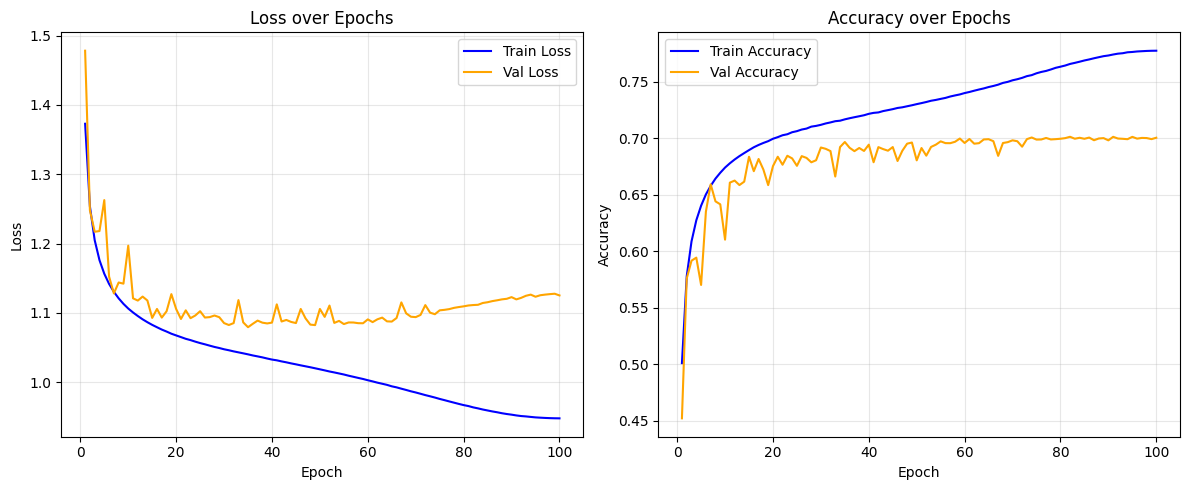

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = Path(f"./experiments/logs/{model_save_name}/{RUN_ID}_learning_curves.csv")
df = pd.read_csv(file_path)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy', color='blue')
plt.plot(df['epoch'], df['val_acc'], label='Val Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

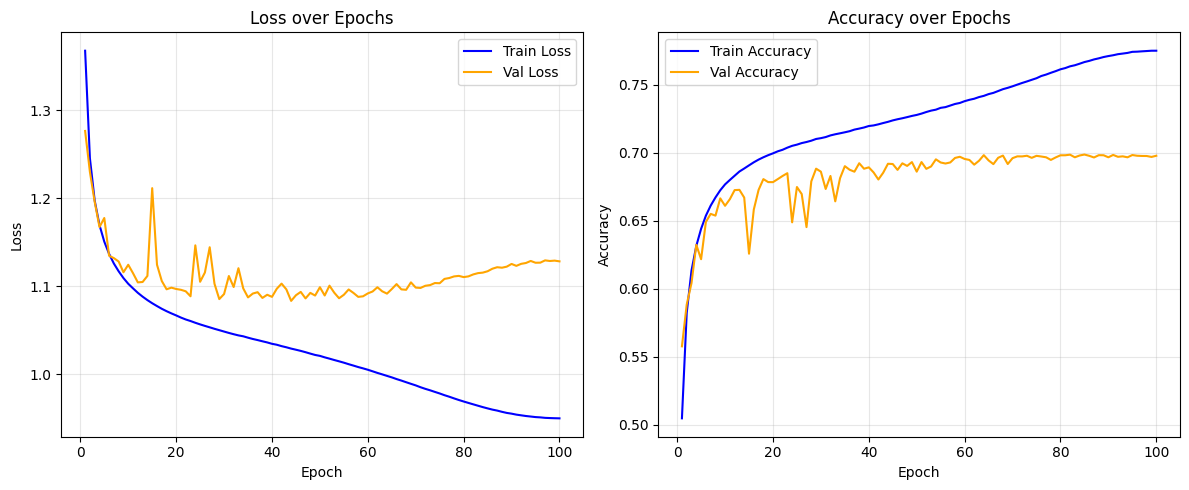

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

file_path = Path(f"./experiments/logs/seresnet_new_v1_16/seresnet_new_v1_16_learning_curves.csv")
df = pd.read_csv(file_path)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy', color='blue')
plt.plot(df['epoch'], df['val_acc'], label='Val Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()